In [1]:
import pandas as pd
import requests
import time
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from tqdm import tqdm

### Premier dataset

In [2]:
url = 'https://projet-incendie.s3.eu-west-3.amazonaws.com/Incendies_2014_2024.csv'

df = pd.read_csv(url, sep=';', encoding='utf-8', skiprows=3)
pd.set_option('display.max_columns', None)

print(df.head(10))
print(df.shape)

   Année  Numéro Département Code INSEE      Nom de la commune  \
0   2014    6330          66      66190      Salses-le-Château   
1   2014    2369          06      06074              Lantosque   
2   2014    2546          2A      2A139                  Lecci   
3   2014       6          65      65173                Esterre   
4   2014    8243          2B      2B058                 Canari   
5   2014       7          65      65233                 Jarret   
6   2014    1997          30      30051  Branoux-les-Taillades   
7   2014    6439          66      66196                 Sorède   
8   2014    6002          2B      2B242         Poggio-Mezzana   
9   2014      56         974      97421                Salazie   

  Date de première alerte  Surface parcourue (m2)  Surface forêt (m2)  \
0     2014-01-02 14:56:00                   10000                 NaN   
1     2014-01-07 13:50:00                   48400                 NaN   
2     2014-01-09 16:14:00                      10     

In [3]:
print("Display of dataset: ")
display(df.head(10))
pd.options.display.max_columns = None 
print()

print("Basics statistics: ")
df_desc = df.describe(include="all")
display(df_desc)
print()

print("Total and percentage of missing values: ")
missing_total = df.isnull().sum().sum()
display(missing_total)
missing_percent = 100 * df.isnull().sum() / df.shape[0]
display(missing_percent[missing_percent != 0])

Display of dataset: 


,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,7,65,65233,Jarret,2014-01-12 16:41:00,200,0.0,NaN,200.0,NaN,NaN,200.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,1997,30,30051,Branoux-les-Taillades,2014-01-13 19:24:00,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,6439,66,66196,Sorède,2014-01-17 16:40:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN
8,2014,6002,2B,2B242,Poggio-Mezzana,2014-01-18 14:57:00,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,56,974,97421,Salazie,2014-01-21 14:08:00,3000,0.0,NaN,3000.0,NaN,NaN,3000.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Basics statistics: 


,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
count,29732.000000,29732.000000,29732,29732,29705,29732,2.973200e+04,2.100500e+04,8.809000e+03,1.453600e+04,4064.000000,4.048000e+03,1.055100e+04,7.620000e+03,7.422000e+03,1.167100e+04,12091,11135.000000,14111,4731,866.000000,867.000000,866.000000,813
unique,NaN,NaN,96,7740,7586,29053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,5,2,NaN,NaN,NaN,1
top,NaN,NaN,13,97415,Saint-Paul,2020-07-30 00:51:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Estimées,NaN,Malveillance,Non,NaN,NaN,NaN,Données partielles ou non valides
freq,NaN,NaN,2688,363,366,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9653,NaN,4593,4690,NaN,NaN,NaN,813
mean,2018.986715,8390.076382,NaN,NaN,NaN,NaN,5.425808e+04,4.481169e+04,4.277521e+04,9.906364e+03,1529.158465,9.097792e+02,8.953332e+03,5.263809e+03,3.538426e+03,1.140125e+04,NaN,1.998383,NaN,NaN,0.003464,0.110727,0.062356,NaN
std,2.991246,6514.790521,NaN,NaN,NaN,NaN,1.115496e+06,1.225440e+06,4.436538e+05,1.234060e+05,22583.735051,3.430465e+04,9.137842e+04,1.225254e+05,4.687192e+04,1.633593e+05,NaN,1.437769,NaN,NaN,0.058789,2.353654,1.032777,NaN
min,2014.000000,1.000000,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,2016.000000,2683.000000,NaN,NaN,NaN,NaN,1.000000e+02,0.000000e+00,2.000000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
50%,2019.000000,7244.000000,NaN,NaN,NaN,NaN,1.000000e+03,1.500000e+02,5.000000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
75%,2022.000000,12175.250000,NaN,NaN,NaN,NaN,1.000000e+04,3.000000e+03,7.900000e+03,3.000000e+02,0.000000,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,NaN,3.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN



Total and percentage of missing values: 


370265

Nom de la commune                              0.090811
Surface forêt (m2)                            29.352213
Surface maquis garrigues (m2)                 70.371990
Autres surfaces naturelles hors forêt (m2)    51.109915
Surfaces agricoles (m2)                       86.331226
Autres surfaces (m2)                          86.385040
Surface autres terres boisées (m2)            64.512983
Surfaces non boisées naturelles (m2)          74.371048
Surfaces non boisées artificialisées (m2)     75.036997
Surfaces non boisées (m2)                     60.745998
Précision des surfaces                        59.333378
Type de peuplement                            62.548769
Nature                                        52.539352
Décès ou bâtiments touchés                    84.087851
Nombre de décès                               97.087313
Nombre de bâtiments totalement détruits       97.083950
Nombre de bâtiments partiellement détruits    97.087313
Précision de la donnée                        97

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29732 entries, 0 to 29731
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Année                                       29732 non-null  int64  
 1   Numéro                                      29732 non-null  int64  
 2   Département                                 29732 non-null  object 
 3   Code INSEE                                  29732 non-null  object 
 4   Nom de la commune                           29705 non-null  object 
 5   Date de première alerte                     29732 non-null  object 
 6   Surface parcourue (m2)                      29732 non-null  int64  
 7   Surface forêt (m2)                          21005 non-null  float64
 8   Surface maquis garrigues (m2)               8809 non-null   float64
 9   Autres surfaces naturelles hors forêt (m2)  14536 non-null  float64
 10  Surfaces a

In [5]:
communes = df["Nom de la commune"]
communes_uniques = communes.unique()
liste_communes = communes.unique().tolist()

print(liste_communes[0:10])

['Salses-le-Château', 'Lantosque', 'Lecci', 'Esterre', 'Canari', 'Jarret', 'Branoux-les-Taillades', 'Sorède', 'Poggio-Mezzana', 'Salazie']


#### Test API Nominatim et requête

In [6]:
r = requests.get('https://nominatim.openstreetmap.org/search')
r

<Response [200]>

In [7]:
# url = "https://nominatim.openstreetmap.org/search"
# headers = {
#     "User-Agent": "MyGeocoder/1.0 (myemail@example.com)"
# }
# output_file = "coordonnees_villes.csv"
# delay = 1  # en secondes, respect de la limite Nominatim
# places = [p for p in liste_communes if pd.notna(p)]

# # Charger les données déjà géocodées si le fichier existe
# if os.path.exists(output_file):
#     existing_df = pd.read_csv(output_file)
#     done_places = set(existing_df["ville"])
#     data_list = existing_df.to_dict("records")
# else:
#     done_places = set()
#     data_list = []

# # Boucle principale avec reprise
# for place in tqdm(places, desc="Géocodage des communes"):
#     place_str = str(place).strip()
#     if place_str in done_places:
#         continue  # éviter les doublons déjà traités

#     params = {
#         "q": place_str + ", France",
#         "format": "json",
#         "limit": 1
#     }

#     try:
#         response = requests.get(url, params=params, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             if data:
#                 lat = data[0].get("lat")
#                 lon = data[0].get("lon")
#             else:
#                 lat, lon = None, None
#         else:
#             lat, lon = None, None

#     except Exception as e:
#         print(f"Erreur pour {place_str} : {e}")
#         lat, lon = None, None

#     data_list.append({"ville": place_str, "latitude": lat, "longitude": lon})
#     done_places.add(place_str)

#     # Sauvegarde après chaque ville
#     pd.DataFrame(data_list).to_csv(output_file, index=False)

#     # Pause pour respecter la limite Nominatim
#     time.sleep(delay)

# print("\n✅ Géocodage terminé. Données enregistrées dans :", output_file)

#### Second DF

In [8]:
df2 = pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Incendies_2006_2013.csv', sep=';', encoding='utf-8', skiprows=6)
pd.set_option('display.max_columns', None)
df2.head(10)

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2006,8806,66,66179,Saint-Laurent-de-Cerdans,2006-01-01 12:50:00,10000,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,Naturelle,NaN,NaN,NaN,NaN,NaN
1,2006,8917,66,66190,Salses-le-Château,2006-01-01 12:56:00,20000,0.0,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
2,2006,4695,83,83028,Callas,2006-01-01 15:40:00,30,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
3,2006,8028,34,34237,Roujan,2006-01-02 18:19:00,37500,10000.0,27500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,Malveillance,NaN,NaN,NaN,NaN,NaN
4,2006,5806,83,83050,Draguignan,2006-01-02 20:57:00,200,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN
5,2006,7696,48,48152,Saint-Frézal-de-Ventalon,2006-01-03 15:31:00,250,50.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Accidentelle,NaN,NaN,NaN,NaN,NaN
6,2006,5362,83,83049,Cuers,2006-01-04 13:15:00,400,400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
7,2006,5473,06,06101,Rigaud,2006-01-04 15:54:00,2500,0.0,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2006,8362,06,06101,Rigaud,2006-01-05 15:24:00,500,0.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2006,6943,13,13098,Saint-Mitre-les-Remparts,2006-01-05 17:06:00,10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
communes2 = df2["Nom de la commune"]
communes_uniques2 = communes2.unique()
liste_communes2 = communes2.unique().tolist()

print(liste_communes2[0:10])

['Saint-Laurent-de-Cerdans', 'Salses-le-Château', 'Callas', 'Roujan', 'Draguignan', 'Saint-Frézal-de-Ventalon', 'Cuers', 'Rigaud', 'Saint-Mitre-les-Remparts', 'Salignac-Eyvigues']


#### Fusion des listes de villes sans doublon

In [10]:
liste_complete = list(set(liste_communes + liste_communes2))
print(liste_complete[0:10])

['Houssay', 'Aiguèze', 'Barbezieux-Saint-Hilaire', 'Beynac-et-Cazenac', 'Hautecourt-Romanèche', 'Vesc', 'Trégarvan', 'Cieurac', "Noirmoutier-en-l'Île", 'Le Bouchet']


#### Requête des coordonnées GPS en ne rajoutant que les nouvelles villes

In [11]:
# url = "https://nominatim.openstreetmap.org/search"
# headers = {
#     "User-Agent": "MyGeocoder/1.0 (myemail@example.com)"
# }
# output_file = "coordonnees_villes.csv"
# delay = 1  # en secondes, respect de la limite Nominatim
# places = [p for p in liste_complete if pd.notna(p)]

# # Charger les données déjà géocodées si le fichier existe
# if os.path.exists(output_file):
#     existing_df = pd.read_csv(output_file)
#     done_places = set(existing_df["ville"])
#     data_list = existing_df.to_dict("records")
# else:
#     done_places = set()
#     data_list = []

# # Boucle principale avec reprise
# for place in tqdm(places, desc="Géocodage des communes"):
#     place_str = str(place).strip()
#     if place_str in done_places:
#         continue  # éviter les doublons déjà traités

#     params = {
#         "q": place_str + ", France",
#         "format": "json",
#         "limit": 1
#     }

#     try:
#         response = requests.get(url, params=params, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             if data:
#                 lat = data[0].get("lat")
#                 lon = data[0].get("lon")
#             else:
#                 lat, lon = None, None
#         else:
#             lat, lon = None, None

#     except Exception as e:
#         print(f"Erreur pour {place_str} : {e}")
#         lat, lon = None, None

#     data_list.append({"ville": place_str, "latitude": lat, "longitude": lon})
#     done_places.add(place_str)

#     # Sauvegarde après chaque ville
#     pd.DataFrame(data_list).to_csv(output_file, index=False)

#     # Pause pour respecter la limite Nominatim
#     time.sleep(delay)

# print("\n✅ Géocodage terminé. Données enregistrées dans :", output_file)

In [12]:
url_ville = 'https://projet-incendie.s3.eu-west-3.amazonaws.com/coordonnees_villes.csv'
coords=pd.read_csv(url_ville, sep=',', encoding='utf-8')
coords.head(10)

,ville,latitude,longitude
0,Salses-le-Château,42.833380,2.918180
1,Lantosque,43.973468,7.312593
2,Lecci,41.679373,9.317798
3,Esterre,42.874901,0.006078
4,Canari,42.845933,9.331333
5,Jarret,43.082300,-0.014354
6,Branoux-les-Taillades,44.219600,3.991240
7,Sorède,42.530402,2.956454
8,Poggio-Mezzana,42.397680,9.493930
9,Salazie,-21.024383,55.543545


In [13]:
coords.rename(columns={"ville": "Nom de la commune"}, inplace=True)
coords.head(5)

,Nom de la commune,latitude,longitude
0,Salses-le-Château,42.833380,2.918180
1,Lantosque,43.973468,7.312593
2,Lecci,41.679373,9.317798
3,Esterre,42.874901,0.006078
4,Canari,42.845933,9.331333


In [14]:
coords=coords.dropna(subset=['latitude', 'longitude'])
coords.isna().sum()

Nom de la commune    0
latitude             0
longitude            0
dtype: int64

### Vérification visuelle de la pertinence des coordonnées GPS

In [15]:
fig = px.scatter_mapbox(
    coords, 
    lat="latitude", 
    lon="longitude", 
    hover_name="Nom de la commune",
    height=1000,
    zoom=5,
    mapbox_style="carto-positron")
fig.show()

#### Fusion des csv des incendies

In [16]:
df_concat = pd.concat([df, df2], ignore_index=True)
df_concat.to_csv("Incendies_2006_2024.csv", index=False, sep=';')

df_concat.head(10)

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,7,65,65233,Jarret,2014-01-12 16:41:00,200,0.0,NaN,200.0,NaN,NaN,200.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,1997,30,30051,Branoux-les-Taillades,2014-01-13 19:24:00,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,6439,66,66196,Sorède,2014-01-17 16:40:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN
8,2014,6002,2B,2B242,Poggio-Mezzana,2014-01-18 14:57:00,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,56,974,97421,Salazie,2014-01-21 14:08:00,3000,0.0,NaN,3000.0,NaN,NaN,3000.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_concat.isna().sum()/len(df_concat)*100

Année                                          0.000000
Numéro                                         0.000000
Département                                    0.000000
Code INSEE                                     0.000000
Nom de la commune                              0.053792
Date de première alerte                        0.000000
Surface parcourue (m2)                         0.000000
Surface forêt (m2)                            23.284123
Surface maquis garrigues (m2)                 60.745522
Autres surfaces naturelles hors forêt (m2)    58.283028
Surfaces agricoles (m2)                       91.903253
Autres surfaces (m2)                          91.935130
Surface autres terres boisées (m2)            66.222382
Surfaces non boisées naturelles (m2)          79.190325
Surfaces non boisées artificialisées (m2)     79.722272
Surfaces non boisées (m2)                     43.211205
Précision des surfaces                        73.912697
Type de peuplement                            59

### Traitement de la date

In [18]:
df_concat=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Incendies_2006_2024.csv', sep=';', encoding='utf-8')
df_concat['Date de première alerte'] = pd.to_datetime(df_concat['Date de première alerte'])
type(df_concat['Date de première alerte'][0])

C:\Users\joelt\AppData\Local\Temp\ipykernel_6384\1755465163.py:1: DtypeWarning:

Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.



pandas._libs.tslibs.timestamps.Timestamp

In [19]:
df_concat['année'] = df_concat['Date de première alerte'].dt.year
df_concat['mois'] = df_concat['Date de première alerte'].dt.month
df_concat['jour'] = df_concat['Date de première alerte'].dt.day
df_concat['heure'] = df_concat['Date de première alerte'].dt.hour

display(df_concat.head(10))
pd.options.display.max_columns = None 
print()

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Type de peuplement,Nature,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée,année,mois,jour,heure
0,2014,6330,66,66190,Salses-le-Château,2014-01-02 14:56:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,2014,1,2,14
1,2014,2369,06,06074,Lantosque,2014-01-07 13:50:00,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,7,13
2,2014,2546,2A,2A139,Lecci,2014-01-09 16:14:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16
3,2014,6,65,65173,Esterre,2014-01-10 20:04:00,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,10,20
4,2014,8243,2B,2B058,Canari,2014-01-11 14:00:00,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14
5,2014,7,65,65233,Jarret,2014-01-12 16:41:00,200,0.0,NaN,200.0,NaN,NaN,200.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,12,16
6,2014,1997,30,30051,Branoux-les-Taillades,2014-01-13 19:24:00,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,13,19
7,2014,6439,66,66196,Sorède,2014-01-17 16:40:00,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN,2014,1,17,16
8,2014,6002,2B,2B242,Poggio-Mezzana,2014-01-18 14:57:00,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,18,14
9,2014,56,974,97421,Salazie,2014-01-21 14:08:00,3000,0.0,NaN,3000.0,NaN,NaN,3000.0,0.0,0.0,0.0,Estimées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,21,14


In [20]:
df_concat.drop(df_concat.columns[[0, 1, 5, 16, 19, 20, 21, 22, 23]], axis=1, inplace=True)

display(df_concat.head(10))

,Département,Code INSEE,Nom de la commune,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,année,mois,jour,heure
0,66,66190,Salses-le-Château,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),2014,1,2,14
1,06,06074,Lantosque,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2014,1,7,13
2,2A,2A139,Lecci,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16
3,65,65173,Esterre,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,2014,1,10,20
4,2B,2B058,Canari,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14
5,65,65233,Jarret,200,0.0,NaN,200.0,NaN,NaN,200.0,0.0,0.0,0.0,NaN,NaN,2014,1,12,16
6,30,30051,Branoux-les-Taillades,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,13,19
7,66,66196,Sorède,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (travaux),2014,1,17,16
8,2B,2B242,Poggio-Mezzana,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,18,14
9,974,97421,Salazie,3000,0.0,NaN,3000.0,NaN,NaN,3000.0,0.0,0.0,0.0,NaN,NaN,2014,1,21,14


##### Traitement des Nan

In [21]:
nb_null = df_concat['Nom de la commune'].isnull().sum()
print(nb_null)

27


In [22]:
df_concat = df_concat.dropna(subset=['Nom de la commune'])
print(df_concat['Nom de la commune'].isnull().sum())

0


### Rajout des coordonnées GPS

In [23]:
df_merge = df_concat.merge(coords[["Nom de la commune", "latitude", "longitude"]], 
                    on="Nom de la commune", 
                    how="left")
df_merge.head(5)

,Département,Code INSEE,Nom de la commune,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,année,mois,jour,heure,latitude,longitude
0,66,66190,Salses-le-Château,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),2014,1,2,14,42.833380,2.918180
1,06,06074,Lantosque,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2014,1,7,13,43.973468,7.312593
2,2A,2A139,Lecci,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16,41.679373,9.317798
3,65,65173,Esterre,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,2014,1,10,20,42.874901,0.006078
4,2B,2B058,Canari,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14,42.845933,9.331333


In [24]:
colonnes = df_merge.columns.tolist()
colonnes.remove("latitude")
colonnes.remove("longitude")

colonnes.insert(3, "latitude")
colonnes.insert(4, "longitude")

df_merge = df_merge[colonnes]

df_merge.head(5)

,Département,Code INSEE,Nom de la commune,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,année,mois,jour,heure
0,66,66190,Salses-le-Château,42.833380,2.918180,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),2014,1,2,14
1,06,06074,Lantosque,43.973468,7.312593,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2014,1,7,13
2,2A,2A139,Lecci,41.679373,9.317798,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16
3,65,65173,Esterre,42.874901,0.006078,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,2014,1,10,20
4,2B,2B058,Canari,42.845933,9.331333,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14


In [25]:
df_merge.to_csv("historique_incendies_avec_coordonnees.csv", index=False, sep=';')

#### Visu des causes d'incendie

In [26]:
df_merge=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/historique_incendies_avec_coordonnees.csv', sep=';', encoding='utf-8')

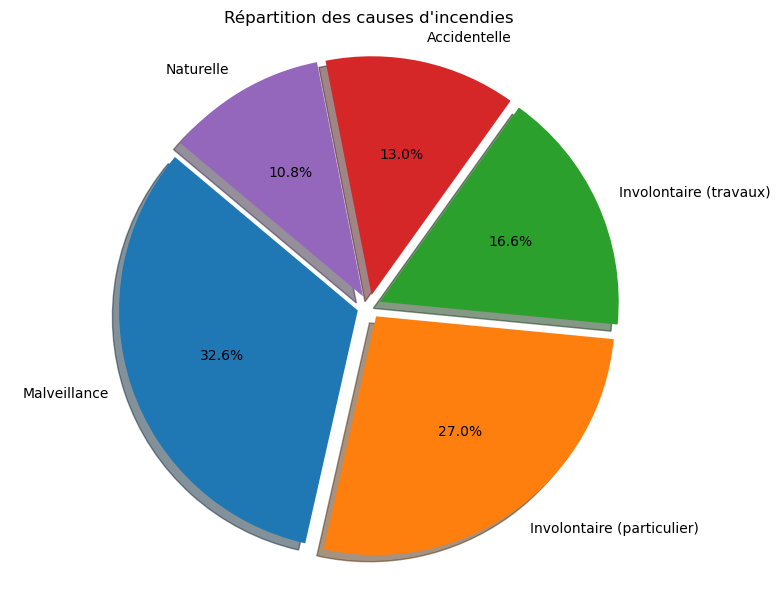

In [27]:
causes = df_merge['Nature'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(causes.values, labels=causes.index,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05]*len(causes))

plt.title("Répartition des causes d'incendies")
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Visu de l'historique des feux

In [28]:
# Renommer temporairement les colonnes
df_temp = df_merge.rename(columns={
    'année': 'year',
    'mois': 'month',
    'jour': 'day'
})

# Créer la colonne 'date'
df_merge['date'] = pd.to_datetime(df_temp[['year', 'month', 'day']])


In [29]:
# 1. Créer colonne date si ce n'est pas encore fait
df_temp = df_merge.rename(columns={'année': 'year', 'mois': 'month', 'jour': 'day'})
df_merge['date'] = pd.to_datetime(df_temp[['year', 'month', 'day']])

# 2. Extraire mois (numérique) et année
df_merge['mois'] = df_merge['date'].dt.month
df_merge['année'] = df_merge['date'].dt.year

# 3. Convertir mois en noms abrégés et ordonnés
mois_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_merge['mois_nom'] = df_merge['mois'].apply(lambda x: mois_abbr[x - 1])

# 4. Forcer l'ordre des mois (important pour affichage correct)
df_merge['mois_nom'] = pd.Categorical(df_merge['mois_nom'],
    categories=mois_abbr,
    ordered=True
)

# 5. Grouper par mois et année
df_grouped = df_merge.groupby(['mois_nom', 'année']).size().reset_index(name='nombre_feux')

# 6. Graphique comparatif
fig = px.bar(
    df_grouped,
    x='mois_nom',
    y='nombre_feux',
    color='année',
    barmode='group',
    title='Comparaison mensuelle des incendies par année',
    height=600,
    width=1000
)

fig.update_layout(
    xaxis_title='Mois',
    yaxis_title='Nombre de feux',
    xaxis_tickangle=-45
)

fig.show()


C:\Users\joelt\AppData\Local\Temp\ipykernel_6384\764402409.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [30]:
df_merge.head()

,Département,Code INSEE,Nom de la commune,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,année,mois,jour,heure,date,mois_nom
0,66,66190,Salses-le-Château,42.833380,2.918180,10000,NaN,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Involontaire (particulier),2014,1,2,14,2014-01-02,Jan
1,06,06074,Lantosque,43.973468,7.312593,48400,NaN,48400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2014,1,7,13,2014-01-07,Jan
2,2A,2A139,Lecci,41.679373,9.317798,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16,2014-01-09,Jan
3,65,65173,Esterre,42.874901,0.006078,10000,10000.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,2014,1,10,20,2014-01-10,Jan
4,2B,2B058,Canari,42.845933,9.331333,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14,2014-01-11,Jan


#### Test de cluster avec DBScan

In [31]:
# 1. Grouper pour compter la fréquence d'apparition
commune_counts = df_merge.groupby(['Nom de la commune', 'latitude', 'longitude']).size().reset_index(name='frequence')

# 2. Répliquer les lignes selon la fréquence (pondération par duplication)
df_expanded = commune_counts.loc[commune_counts.index.repeat(commune_counts['frequence'])].reset_index(drop=True)

X = df_expanded[['latitude', 'longitude']]

In [32]:
coords_rad = np.radians(df_expanded[['latitude', 'longitude']])
kms_per_radian = 6371.0088
eps_km = 5
eps = eps_km / kms_per_radian
db = DBSCAN(eps=eps, min_samples=20, metric='haversine').fit(coords_rad)
df_expanded['cluster'] = db.labels_

In [33]:
fig = px.scatter_mapbox(

        df_expanded[df_expanded.cluster != -1],
        lat="latitude",
        lon="longitude",
        color="cluster",
        hover_name="Nom de la commune",
        title="Clusters d'incendies en France (2006-2024)",
        zoom=5,
        height = 1000,        
        mapbox_style="carto-positron"
)

fig.show()

### Tests sur la ville d'Ajaccio

In [34]:
start = time.time()

df_merge['Département'] = df_merge['Département'].replace({'2A': '20', '2B': '20'})

# Ajouter les zéros devant (par ex. '1' -> '01')
df_merge['Département'] = df_merge['Département'].astype(str).str.zfill(2)

end = time.time()
print(f"Temps écoulé : {end - start:.2f} secondes")

Temps écoulé : 0.02 secondes


In [35]:
print(df_merge.head())
print(df_merge.shape)

  Département Code INSEE  Nom de la commune   latitude  longitude  \
0          66      66190  Salses-le-Château  42.833380   2.918180   
1          06      06074          Lantosque  43.973468   7.312593   
2          20      2A139              Lecci  41.679373   9.317798   
3          65      65173            Esterre  42.874901   0.006078   
4          20      2B058             Canari  42.845933   9.331333   

   Surface parcourue (m2)  Surface forêt (m2)  Surface maquis garrigues (m2)  \
0                   10000                 NaN                        10000.0   
1                   48400                 NaN                        48400.0   
2                      10                 NaN                            NaN   
3                   10000             10000.0                            NaN   
4                     100                 NaN                            NaN   

   Autres surfaces naturelles hors forêt (m2)  Surfaces agricoles (m2)  \
0                             

In [36]:
# mask=df_merge['Département']=='2A' or df_merge['Département']=='2B'
# pd.set_option('display.max_rows', None)
# df_ajaccio = df_merge[mask]
# df_ajaccio.head(10)

In [37]:
# mask = df_ajaccio['année'] == 2024
# df_ajaccio_2024 = df_ajaccio[mask]
# df_ajaccio_2024.head(10)

In [38]:
# df_merge['Département'] = 20
# df_merge.head()

In [39]:
mask = df_merge['Département'] == '20'
df_corse = df_merge[mask]
df_corse.head()

,Département,Code INSEE,Nom de la commune,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,année,mois,jour,heure,date,mois_nom
2,20,2A139,Lecci,41.679373,9.317798,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16,2014-01-09,Jan
4,20,2B058,Canari,42.845933,9.331333,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14,2014-01-11,Jan
8,20,2B242,Poggio-Mezzana,42.397680,9.493930,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,18,14,2014-01-18,Jan
13,20,2B036,Bigorno,42.527867,9.301862,10000,0.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,26,13,2014-01-26,Jan
14,20,2B341,Venaco,42.231867,9.172566,5000,0.0,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,26,13,2014-01-26,Jan


In [40]:
# Rajout d'une colonne pour indiquer les feux
df_corse['Feux']=1
df_corse

C:\Users\joelt\AppData\Local\Temp\ipykernel_6384\2660332449.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Département,Code INSEE,Nom de la commune,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,année,mois,jour,heure,date,mois_nom,Feux
2,20,2A139,Lecci,41.679373,9.317798,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,9,16,2014-01-09,Jan,1
4,20,2B058,Canari,42.845933,9.331333,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,1,11,14,2014-01-11,Jan,1
8,20,2B242,Poggio-Mezzana,42.397680,9.493930,3000,0.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,18,14,2014-01-18,Jan,1
13,20,2B036,Bigorno,42.527867,9.301862,10000,0.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,26,13,2014-01-26,Jan,1
14,20,2B341,Venaco,42.231867,9.172566,5000,0.0,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,2014,1,26,13,2014-01-26,Jan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50159,20,2B281,Sisco,42.811000,9.488517,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,12,24,14,2013-12-24,Dec,1
50162,20,2B034,Belgodère,42.585869,9.017537,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,12,25,8,2013-12-25,Dec,1
50163,20,2B143,Linguizzetta,42.263690,9.472990,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,12,25,17,2013-12-25,Dec,1
50164,20,2B201,Pancheraccia,42.218682,9.371530,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,12,26,14,2013-12-26,Dec,1


In [41]:
df_corse = df_corse.drop('date', axis=1)
type(df_corse)

pandas.core.frame.DataFrame

In [42]:
df_corse.columns

Index(['Département', 'Code INSEE', 'Nom de la commune', 'latitude',
       'longitude', 'Surface parcourue (m2)', 'Surface forêt (m2)',
       'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Type de peuplement', 'Nature', 'année',
       'mois', 'jour', 'heure', 'mois_nom', 'Feux'],
      dtype='object')

#### Rajout de la météo

In [43]:
df_meteo=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Meteo_corse_complet.csv', sep=';', encoding='utf-8')
df_meteo.head(10)

,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,année,mois,jour,Département,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois
0,16.0,NaN,9.0,NaN,11.5,NaN,NaN,10.25,NaN,NaN,2.5,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,1,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
1,1.5,NaN,7.0,NaN,10.5,NaN,NaN,8.75,NaN,NaN,3.5,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2006,1,2,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
2,0.3,NaN,1.5,NaN,13.0,NaN,NaN,7.25,NaN,NaN,11.5,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,3,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
3,0.2,NaN,1.0,NaN,11.5,NaN,NaN,6.25,NaN,NaN,10.5,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,4,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
4,1.0,NaN,1.5,NaN,12.0,NaN,NaN,6.75,NaN,NaN,10.5,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,5,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
5,0.0,NaN,2.0,NaN,13.5,NaN,NaN,7.75,NaN,NaN,11.5,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,6,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
6,0.0,NaN,4.5,NaN,13.9,NaN,NaN,9.20,NaN,NaN,9.4,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,7,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
7,0.2,NaN,3.5,NaN,13.5,NaN,NaN,8.50,NaN,NaN,10.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,8,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
8,0.0,NaN,3.0,NaN,14.5,NaN,NaN,8.75,NaN,NaN,11.5,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,9,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919
9,0.2,NaN,3.5,NaN,12.5,NaN,NaN,8.00,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,10,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919


In [44]:
# df_meteo['DATE'] = pd.to_datetime(df_meteo['DATE'])
# type(df_meteo['DATE'][0])

In [45]:
# df_meteo['année'] = df_meteo['DATE'].dt.year
# df_meteo['mois'] = df_meteo['DATE'].dt.month
# df_meteo['jour'] = df_meteo['DATE'].dt.day


# display(df_meteo.head(10))
# pd.options.display.max_columns = None 
# print()

In [46]:
df_meteo.shape

(283811, 45)

In [47]:
df_meteo.columns

Index(['RR', 'DRR', 'TN', 'HTN', 'TX', 'HTX', 'TM', 'TMNX', 'TNSOL', 'TN50',
       'TAMPLI', 'TNTXM', 'FFM', 'FXI', 'DXI', 'HXI', 'FXY', 'DXY', 'HXY',
       'FXI3S', 'HXI3S', 'UN', 'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80',
       'TSVM', 'UM', 'ORAG', 'BRUME', 'ETPMON', 'ETPGRILLE', 'année', 'mois',
       'jour', 'Département', 'moyenne precipitations année',
       'moyenne precipitations mois', 'moyenne evapotranspiration année',
       'moyenne evapotranspiration mois', 'moyenne vitesse vent année',
       'moyenne vitesse vent mois', 'moyenne temperature année',
       'moyenne temperature mois'],
      dtype='object')

In [48]:
df_meteo.isna().sum()

RR                                   28107
DRR                                 263374
TN                                   44445
HTN                                  94100
TX                                   44441
HTX                                  94077
TM                                   87440
TMNX                                 45084
TNSOL                               254821
TN50                                254790
TAMPLI                               45084
TNTXM                                45084
FFM                                 134039
FXI                                 137842
DXI                                 138080
HXI                                 139887
FXY                                 148433
DXY                                 148546
HXY                                 148601
FXI3S                               207837
HXI3S                               208280
UN                                  145552
HUN                                 145996
UX         

In [49]:
df_corse.columns

Index(['Département', 'Code INSEE', 'Nom de la commune', 'latitude',
       'longitude', 'Surface parcourue (m2)', 'Surface forêt (m2)',
       'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Type de peuplement', 'Nature', 'année',
       'mois', 'jour', 'heure', 'mois_nom', 'Feux'],
      dtype='object')

In [50]:
df_corse['Département'] = df_corse['Département'].astype(int)
df_corse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9509 entries, 2 to 50165
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   Département                                 9509 non-null   int32   
 1   Code INSEE                                  9509 non-null   object  
 2   Nom de la commune                           9509 non-null   object  
 3   latitude                                    9509 non-null   float64 
 4   longitude                                   9509 non-null   float64 
 5   Surface parcourue (m2)                      9509 non-null   int64   
 6   Surface forêt (m2)                          4304 non-null   float64 
 7   Surface maquis garrigues (m2)               6151 non-null   float64 
 8   Autres surfaces naturelles hors forêt (m2)  562 non-null    float64 
 9   Surfaces agricoles (m2)                     562 non-null    float64 
 10  Autr

In [51]:
df_corse_2 = df_meteo.merge(
                df_corse[["Département", "Code INSEE", "Nom de la commune", "latitude",
                "longitude", "Surface parcourue (m2)", "Surface forêt (m2)",
                "Surface maquis garrigues (m2)",
                "Autres surfaces naturelles hors forêt (m2)", "Surfaces agricoles (m2)",
                "Autres surfaces (m2)", "Surface autres terres boisées (m2)",
                "Surfaces non boisées naturelles (m2)",
                "Surfaces non boisées artificialisées (m2)",
                "Surfaces non boisées (m2)", "Type de peuplement", "Nature", "année",
                "mois", "jour", "Feux"]],  # on ne garde que les colonnes utiles à fusionner
                on=["année", "mois", "jour", "Département"],
                how="left"
)


In [52]:
df_corse_2.head(10)


,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,année,mois,jour,Département,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Code INSEE,Nom de la commune,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux
0,16.0,NaN,9.0,NaN,11.5,NaN,NaN,10.25,NaN,NaN,2.5,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,1,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5,NaN,7.0,NaN,10.5,NaN,NaN,8.75,NaN,NaN,3.5,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2006,1,2,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.3,NaN,1.5,NaN,13.0,NaN,NaN,7.25,NaN,NaN,11.5,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,3,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.2,NaN,1.0,NaN,11.5,NaN,NaN,6.25,NaN,NaN,10.5,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,4,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,1.5,NaN,12.0,NaN,NaN,6.75,NaN,NaN,10.5,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,5,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,NaN,2.0,NaN,13.5,NaN,NaN,7.75,NaN,NaN,11.5,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,6,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,NaN,4.5,NaN,13.9,NaN,NaN,9.20,NaN,NaN,9.4,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,7,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.2,NaN,3.5,NaN,13.5,NaN,NaN,8.50,NaN,NaN,10.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,8,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,NaN,3.0,NaN,14.5,NaN,NaN,8.75,NaN,NaN,11.5,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,9,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.2,NaN,3.5,NaN,12.5,NaN,NaN,8.00,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,10,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_corse_2['Feux'].replace(np.nan, 0, inplace=True)
df_corse_2.head(10)

C:\Users\joelt\AppData\Local\Temp\ipykernel_6384\391733002.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,année,mois,jour,Département,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Code INSEE,Nom de la commune,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux
0,16.0,NaN,9.0,NaN,11.5,NaN,NaN,10.25,NaN,NaN,2.5,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,1,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1.5,NaN,7.0,NaN,10.5,NaN,NaN,8.75,NaN,NaN,3.5,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2006,1,2,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0.3,NaN,1.5,NaN,13.0,NaN,NaN,7.25,NaN,NaN,11.5,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,3,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0.2,NaN,1.0,NaN,11.5,NaN,NaN,6.25,NaN,NaN,10.5,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,4,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1.0,NaN,1.5,NaN,12.0,NaN,NaN,6.75,NaN,NaN,10.5,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,5,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,0.0,NaN,2.0,NaN,13.5,NaN,NaN,7.75,NaN,NaN,11.5,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,6,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,0.0,NaN,4.5,NaN,13.9,NaN,NaN,9.20,NaN,NaN,9.4,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,7,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,0.2,NaN,3.5,NaN,13.5,NaN,NaN,8.50,NaN,NaN,10.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,8,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,0.0,NaN,3.0,NaN,14.5,NaN,NaN,8.75,NaN,NaN,11.5,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,9,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,0.2,NaN,3.5,NaN,12.5,NaN,NaN,8.00,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,1,10,20,1.731077,3.075112,3.325753,1.32346,3.525229,3.789412,15.162838,7.558919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [54]:
df_corse_2.shape

(511143, 62)

In [57]:
df_corse_2.to_csv("Meteo_incendies.csv", index=False, sep=';')

In [56]:
# corse_complet = pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/Meteo_corse_complet.csv', sep=';', encoding='utf-8')
# corse_complet.head(10)